In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [2]:
train_limpio = pd.read_csv("train_limpio_con_BOW_de_5000_y_Stemming_noDrops.csv",encoding = "ISO-8859-1").sample(frac=1).reset_index(drop=True)
test_limpio = pd.read_csv("test_limpio_con_BOW_de_5000_y_Stemming_noDrops.csv",encoding = "ISO-8859-1").sample(frac=1).reset_index(drop=True)

In [3]:
train_limpio["text"] = train_limpio["text"].map(lambda x : "null" if(x is None) else x)
test_limpio["text"] = test_limpio["text"].map(lambda x : "null" if(x is None) else x)

In [4]:
train_limpio_true = train_limpio.loc[train_limpio["target"] == 1]
train_limpio_false = train_limpio.loc[train_limpio["target"] == 0]

In [5]:
print("Tenemos {cant_verdaderos: .2f} verdaderos y {cant_falsos: .2f} falsos".format(cant_verdaderos=len(train_limpio_true), cant_falsos=len(train_limpio_false)))

Tenemos  3271.00 verdaderos y  4342.00 falsos


## Voy a balancear el train y el validation, misma cantidad de falsos y verdaderos en ambos

In [6]:
train = pd.concat([train_limpio_true.iloc[:2616], train_limpio_false.iloc[:3473]])
val = pd.concat([train_limpio_true.iloc[2616:3000], train_limpio_false.iloc[3473:3850]])
test = pd.concat([train_limpio_true.iloc[3000:], train_limpio_false.iloc[3850:]])

In [7]:
train.head(2)

,aa,ab,aba,abandon,abbott,abbswinston,abc,abcnew,abe,abil,...,wound-keyword,wreck-keyword,wreckag-keyword,isRealPlace,longitud_tweet,letras_seguidas,sentimiento,objetividad,keyword,location
0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,90,2,0.1000,0.2,NaN,NaN
1,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,130,2,-0.1875,0.5,attack,London.


In [8]:
vectorizer = CountVectorizer()
vectorizer.fit(train_limpio["text"].values.astype('U'))

X_train = vectorizer.transform(train["text"].values.astype('U'))
X_val  = vectorizer.transform(val["text"].values.astype('U'))
X_test = vectorizer.transform(test["text"].values.astype('U'))

actual_tp_test_only_text = vectorizer.transform(test_limpio["text"].values.astype('U'))

In [9]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

## Primer modelo simple

In [10]:
input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                133800    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 133,811
Trainable params: 133,811
Non-trainable params: 0
_________________________________________________________________


In [11]:
first_history = model.fit(X_train, train["target"].to_numpy(),
                    epochs=100,
                    verbose=True,
                    validation_data=(X_val, val["target"].to_numpy()),
                    batch_size=10)

Epoch 1/100
609/609 [==============================] - 1s 1ms/step - loss: 0.5378 - acc: 0.7620 - val_loss: 0.4828 - val_acc: 0.7753
Epoch 2/100
609/609 [==============================] - 1s 1ms/step - loss: 0.3392 - acc: 0.8680 - val_loss: 0.4808 - val_acc: 0.7806
Epoch 3/100
609/609 [==============================] - 1s 1ms/step - loss: 0.2323 - acc: 0.9190 - val_loss: 0.5097 - val_acc: 0.7806
Epoch 4/100
609/609 [==============================] - 1s 862us/step - loss: 0.1662 - acc: 0.9409 - val_loss: 0.5546 - val_acc: 0.7700
Epoch 5/100
609/609 [==============================] - 1s 972us/step - loss: 0.1230 - acc: 0.9594 - val_loss: 0.6038 - val_acc: 0.7582
Epoch 6/100
609/609 [==============================] - 1s 1ms/step - loss: 0.0952 - acc: 0.9668 - val_loss: 0.6668 - val_acc: 0.7556
Epoch 7/100
609/609 [==============================] - 1s 1ms/step - loss: 0.0791 - acc: 0.9732 - val_loss: 0.7187 - val_acc: 0.7464
Epoch 8/100
609/609 [==============================] - 1s 1ms/ste

Epoch 62/100
609/609 [==============================] - 1s 1ms/step - loss: 0.0290 - acc: 0.9851 - val_loss: 1.9334 - val_acc: 0.7083
Epoch 63/100
609/609 [==============================] - 1s 1ms/step - loss: 0.0287 - acc: 0.9852 - val_loss: 1.9320 - val_acc: 0.7122
Epoch 64/100
609/609 [==============================] - 1s 1ms/step - loss: 0.0283 - acc: 0.9846 - val_loss: 1.9366 - val_acc: 0.7122
Epoch 65/100
609/609 [==============================] - 1s 1ms/step - loss: 0.0289 - acc: 0.9847 - val_loss: 1.9497 - val_acc: 0.7122
Epoch 66/100
609/609 [==============================] - 1s 1ms/step - loss: 0.0289 - acc: 0.9844 - val_loss: 1.9375 - val_acc: 0.7148
Epoch 67/100
609/609 [==============================] - 1s 1ms/step - loss: 0.0284 - acc: 0.9852 - val_loss: 1.9207 - val_acc: 0.7135
Epoch 68/100
609/609 [==============================] - 1s 1ms/step - loss: 0.0283 - acc: 0.9860 - val_loss: 1.9367 - val_acc: 0.7148
Epoch 69/100
609/609 [==============================] - 1s 887

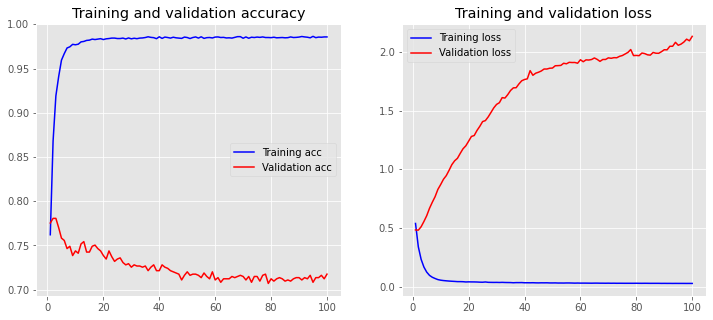

In [12]:
plot_history(first_history)

In [13]:
loss, accuracy = model.evaluate(X_test, test["target"].to_numpy(), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.7261


In [14]:
firstPredictions = list(map(lambda x: x[0], model.predict_classes(actual_tp_test_only_text)))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [15]:
firstPredictionsDF = pd.DataFrame(data={'id': test_limpio["id"], 'target': firstPredictions})
firstPredictionsDF.head(10)

,id,target
0,1695,1
1,4818,1
2,2904,1
3,4999,0
4,9891,0
5,3931,0
6,6117,0
7,9189,1
8,6471,1
9,10324,1


In [16]:
firstPredictionsDF.to_csv('NN_predictions_first_model.csv', index=False)

## Segundo modelo, agrego ciudades y Tokenizer en vez de count para las words

In [17]:
non_null_locations = train_limpio[train_limpio.location.notnull()]["location"].to_numpy()
non_null_locations

array(['London.', 'Nairobi-KENYA', 'USA', ..., 'denmark', 'sweden',
       'Hong Kong'], dtype=object)

In [18]:
encoder = LabelEncoder()
locations = encoder.fit_transform(non_null_locations)
len(locations)

5080

In [19]:
encoder = OneHotEncoder(sparse=False)
locations = locations.reshape((5080, 1))
encoder.fit_transform(locations)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [20]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_limpio["text"].values.astype('U'))

X_train = tokenizer.texts_to_sequences(train["text"].values.astype('U'))
X_val = tokenizer.texts_to_sequences(val["text"].values.astype('U'))
X_test = tokenizer.texts_to_sequences(test["text"].values.astype('U'))

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(train_limpio["text"].values[2])
print(X_train[2])

cartoon bear without them we would qave no knowlddg of forest fire or toilet paper
[69, 3, 140, 3781, 1372, 75, 27, 3009, 72, 115, 1, 140, 99, 609, 1579]


In [21]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

## Pruebo solo texto, modelo mas complejo con maxPooling y mejor embedding

In [22]:
embedding_dim = 50

model1 = Sequential()
model1.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model1.add(layers.GlobalMaxPool1D())
model1.add(layers.Dense(10, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           675500    
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 676,021
Trainable params: 676,021
Non-trainable params: 0
_________________________________________________________________


Testing Accuracy:  0.7785


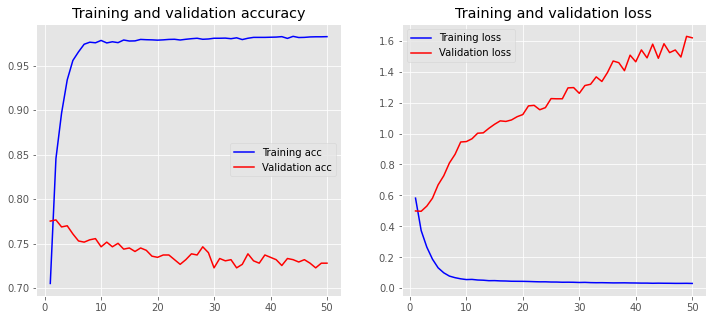

In [23]:
second_history = model1.fit(X_train, train["target"].to_numpy(),
                    epochs=50,
                    verbose=False,
                    validation_data=(X_val, val["target"].to_numpy()),
                    batch_size=10)

loss, accuracy = model1.evaluate(X_test, test["target"].to_numpy(), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(second_history)

## Tercer modelo

In [24]:
embedding_dim = 100

model2 = Sequential()
model2.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model2.add(layers.Conv1D(128, 5, activation='relu'))
model2.add(layers.GlobalMaxPooling1D())
model2.add(layers.Dense(10, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1351000   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 1,416,429
Trainable params: 1,416,429
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
609/609 [==============================] - 8s 13ms/step - loss: 0.5230 - acc: 0.7336 - val_loss: 0.4824 - val_acc: 0.7819
Epoch 2/10
609/609 [==============================] - 10s 16ms/step - loss: 0.3224 - acc: 0.8694 - val_loss: 0.5006 - val_acc: 0.7924
Epoch 3/10
609/609 [==============================] - 8s 14ms/step - loss: 0.2015 - acc: 0.9274 - val_loss: 0.5841 - val_acc: 0.7687
Epoch 4/10
609/609 [==============================] - 7s 12ms/step - loss: 0.1269 - acc: 0.9583 - val_loss: 0.6831 - val_acc: 0.7608
Epoch 5/10
609/609 [==============================] - 8s 13ms/step - loss: 0.0857 - acc: 0.9721 - val_loss: 0.6507 - val_acc: 0.7569
Epoch 6/10
609/609 [==============================] - 8s 13ms/step - loss: 0.0615 - acc: 0.9777 - val_loss: 0.8789 - val_acc: 0.7556
Epoch 7/10
609/609 [==============================] - 7s 11ms/step - loss: 0.0474 - acc: 0.9800 - val_loss: 0.9585 - val_acc: 0.7635
Epoch 8/10
609/609 [==============================] - 7s 12ms/step -

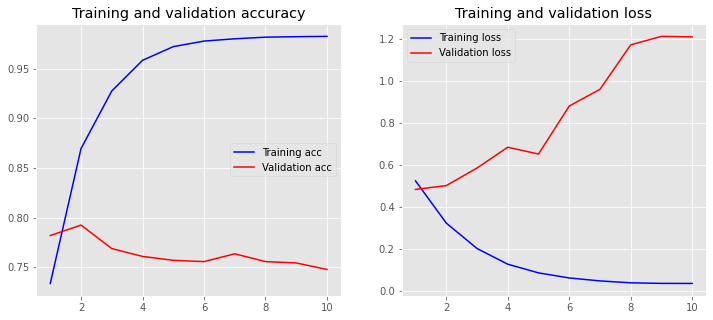

In [25]:
third_history = model2.fit(X_train, train["target"].to_numpy(),
                    epochs=10,
                    verbose=True,
                    validation_data=(X_val, val["target"].to_numpy()),
                    batch_size=10)
loss, accuracy = model2.evaluate(X_train, train["target"].to_numpy(), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model2.evaluate(X_test, test["target"].to_numpy(), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(third_history)


## Cuarto Modelo

In [26]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model3 = Sequential()
    model3.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model3.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model3.add(layers.GlobalMaxPooling1D())
    model3.add(layers.Dense(10, activation='relu'))
    model3.add(layers.Dense(1, activation='sigmoid'))
    model3.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model3

param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])

In [27]:
# # Main settings
# epochs = 20
# embedding_dim = 50
# maxlen = 100
# output_file = 'output.txt'

# source = "twitter"
# # Run grid search for each source (yelp, amazon, imdb)
# print('Running grid search for data set :', "twitter")
# sentences = train_limpio["text"].values.astype('U')
# # Train-test split
# train = pd.concat([train_limpio_true.iloc[:3000], train_limpio_false.iloc[:4000]]).sample(frac=1).reset_index(drop=True)
# test = pd.concat([train_limpio_true.iloc[3000:], train_limpio_false.iloc[4000:]]).sample(frac=1).reset_index(drop=True)

# # Tokenize words
# tokenizer = Tokenizer(num_words=5000)
# tokenizer.fit_on_texts(sentences)
# X_train = tokenizer.texts_to_sequences(train["text"].values.astype('U'))
# X_test = tokenizer.texts_to_sequences(test["text"].values.astype('U'))

# # Adding 1 because of reserved 0 index
# vocab_size = len(tokenizer.word_index) + 1

# # Pad sequences with zeros
# X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
# X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# # Parameter grid for grid search
# param_grid = dict(num_filters=[32, 64, 128],
#                       kernel_size=[3, 5, 7],
#                       vocab_size=[vocab_size],
#                       embedding_dim=[embedding_dim],
#                       maxlen=[maxlen])
# model3 = KerasClassifier(build_fn=create_model,
#                         epochs=epochs, batch_size=10,
#                             verbose=False)
# grid = RandomizedSearchCV(estimator=model3, param_distributions=param_grid,
#                               cv=10, verbose=1, n_iter=10)
# grid_result = grid.fit(X_train, train["target"])

# # Evaluate testing set
# test_accuracy = grid.score(X_test, test["target"])

# # Save and evaluate results
# #     prompt = input(f'finished {source}; write to file and proceed? [y/n]')
# #     if prompt.lower() not in {'y', 'true', 'yes'}:
# #         break
# #     with open(output_file, 'w+') as f:
# s = ('Running {} data set\nBest Accuracy : '
#              '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
# output_string = s.format(
#         source,
#         grid_result.best_score_,
#         grid_result.best_params_,
#         test_accuracy)
# print(output_string)
# #         f.write(output_string)

# Modelo con tf idf

In [28]:
train_limpio_tf_idf = pd.read_csv("train_limpio_con_Tf-Idf.csv",encoding = "ISO-8859-1").sample(frac=1).reset_index(drop=True)
test_limpio_tf_idf = pd.read_csv("test_limpio_con_Tf-Idf.csv",encoding = "ISO-8859-1").sample(frac=1).reset_index(drop=True)

In [29]:
train_limpio_tf_idf = train_limpio_tf_idf.drop(columns=["id"])

In [30]:
train_limpio_tf_idf_true = train_limpio_tf_idf.loc[train_limpio_tf_idf["target"] == 1]
train_limpio_tf_idf_false = train_limpio_tf_idf.loc[train_limpio_tf_idf["target"] == 0]

In [31]:
train_tf_idf = pd.concat([train_limpio_tf_idf_true.iloc[:2616], train_limpio_tf_idf_false.iloc[:3473]])
val_tf_idf = pd.concat([train_limpio_tf_idf_true.iloc[2616:3000], train_limpio_tf_idf_false.iloc[3473:3850]])
test_tf_idf = pd.concat([train_limpio_tf_idf_true.iloc[3000:], train_limpio_tf_idf_false.iloc[3850:]])

In [32]:
x_train_tf_idf = train_tf_idf.iloc[:, :2392]
x_val_tf_idf = val_tf_idf.iloc[:, :2392]
x_test_tf_idf = test_tf_idf.iloc[:, :2392]

In [33]:
input_dim_tf_idf = x_train_tf_idf.shape[1]  # Number of features

modelTfIdf = Sequential()
modelTfIdf.add(layers.Dense(10, input_dim=input_dim_tf_idf, activation='relu'))
modelTfIdf.add(layers.Dense(1, activation='sigmoid'))

modelTfIdf.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['acc'])
modelTfIdf.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 10)                23930     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 23,941
Trainable params: 23,941
Non-trainable params: 0
_________________________________________________________________


In [34]:
first_history_tf_idf = modelTfIdf.fit(x_train_tf_idf.values, train_tf_idf["target"].to_numpy(),
                    epochs=22,
                    verbose=True,
                    validation_data=(x_val_tf_idf.values, val_tf_idf["target"].to_numpy()),
                    batch_size=10)

Epoch 1/22
609/609 [==============================] - 1s 941us/step - loss: 0.6040 - acc: 0.7096 - val_loss: 0.5220 - val_acc: 0.7648
Epoch 2/22
609/609 [==============================] - 0s 799us/step - loss: 0.4325 - acc: 0.8290 - val_loss: 0.4484 - val_acc: 0.7911
Epoch 3/22
609/609 [==============================] - 1s 842us/step - loss: 0.3624 - acc: 0.8487 - val_loss: 0.4455 - val_acc: 0.7937
Epoch 4/22
609/609 [==============================] - 1s 1ms/step - loss: 0.3253 - acc: 0.8681 - val_loss: 0.4527 - val_acc: 0.7924
Epoch 5/22
609/609 [==============================] - 1s 1ms/step - loss: 0.3002 - acc: 0.8781 - val_loss: 0.4722 - val_acc: 0.7819
Epoch 6/22
609/609 [==============================] - 1s 1ms/step - loss: 0.2811 - acc: 0.8844 - val_loss: 0.4928 - val_acc: 0.7845
Epoch 7/22
609/609 [==============================] - 1s 993us/step - loss: 0.2657 - acc: 0.8910 - val_loss: 0.5119 - val_acc: 0.7766
Epoch 8/22
609/609 [==============================] - 1s 835us/step 

In [35]:
loss, accuracy = modelTfIdf.evaluate(x_test_tf_idf.values, test_tf_idf["target"].to_numpy(), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.7667


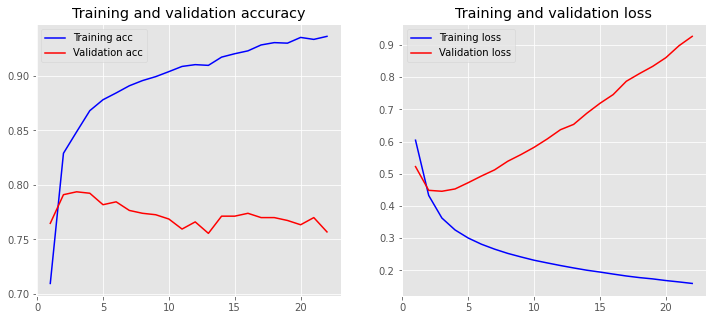

In [36]:
plot_history(first_history_tf_idf)

## Segundo modelo, con conv1D y maxPooling (anda muy mal)

In [39]:
# embedding_dim = 100
# model2_tf_idf = Sequential()
# model2_tf_idf.add(layers.Embedding(2400, embedding_dim, input_length=2392))
# model2_tf_idf.add(layers.Conv1D(128, 5, activation='relu'))
# model2_tf_idf.add(layers.GlobalMaxPooling1D())
# model2_tf_idf.add(layers.Dense(10, activation='relu'))
# model2_tf_idf.add(layers.Dense(1, activation='sigmoid'))
# model2_tf_idf.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['acc'])
# model2_tf_idf.summary()

In [38]:
# second_history_tf_idf = model2_tf_idf.fit(x_train_tf_idf.values, train_tf_idf["target"].to_numpy(),
#                     epochs=3,
#                     verbose=True,
#                     validation_data=(x_val_tf_idf.values, val_tf_idf["target"].to_numpy()),
#                     batch_size=10)

Epoch 1/3
609/609 [==============================] - 41s 67ms/step - loss: 0.6835 - acc: 0.5704 - val_loss: 0.7006 - val_acc: 0.4954
Epoch 2/3
230/609 [==========>...................] - ETA: 27s - loss: 0.6826 - acc: 0.5687

KeyboardInterrupt: 

In [ ]:
# loss, accuracy = model2_tf_idf.evaluate(x_test_tf_idf.values, test_tf_idf["target"].to_numpy(), verbose=False)
# print("Testing Accuracy:  {:.4f}".format(accuracy))

## Modelo con más features, usando set de datos comun

In [99]:
test_limpio = pd.read_csv("test_limpio_con_BOW_de_5000_y_Stemming.csv",encoding = "ISO-8859-1")
test_limpio = test_limpio.drop(columns=["sentimiento", "objetividad"])
test_limpio.head(1)

,aa,ab,aba,abandon,abbott,abbswinston,abc,abcnew,abe,abil,...,www\.twitch\.tv\/PKSparkxx-location,www\.youtube\.com\?Malkavius2-location,xiumin\'s\ nonexistent\ solos-location,y\(our\)\ boyfriends\ legs\ -location,y\/e\/l-location,yorkshire\\n-location,youtube\.com\/channel\/UCHWTLC9B4ZjUGh7yDlb55Iw-location,zboyer\@washingtontimes\.com-location,longitud_tweet,letras_seguidas
0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,40,2


In [100]:
train_limpio = pd.read_csv("train_limpio_con_BOW_de_5000_y_Stemming.csv",encoding = "ISO-8859-1")
train_limpio = train_limpio.drop(columns=["sentimiento", "objetividad", "id"])
train_limpio.head(1)

,aa,ab,aba,abandon,abbott,abbswinston,abc,abcnew,abe,abil,...,www\.twitch\.tv\/PKSparkxx-location,www\.youtube\.com\?Malkavius2-location,xiumin\'s\ nonexistent\ solos-location,y\(our\)\ boyfriends\ legs\ -location,y\/e\/l-location,yorkshire\\n-location,youtube\.com\/channel\/UCHWTLC9B4ZjUGh7yDlb55Iw-location,zboyer\@washingtontimes\.com-location,longitud_tweet,letras_seguidas
0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,70,2


In [101]:
train_limpio_more_features_true = train_limpio.loc[train_limpio["target"] == 1].sample(frac=1).reset_index(drop=True)
train_limpio_more_features_false = train_limpio.loc[train_limpio["target"] == 0].sample(frac=1).reset_index(drop=True)

In [102]:
train_more_feature = pd.concat([train_limpio_more_features_true.iloc[:2616], train_limpio_more_features_false.iloc[:3473]])
val_more_feature = pd.concat([train_limpio_more_features_true.iloc[2616:3000], train_limpio_more_features_false.iloc[3473:3850]])
test_more_feature = pd.concat([train_limpio_more_features_true.iloc[3000:], train_limpio_more_features_false.iloc[3850:]])

In [103]:
input_dim = train_more_feature.drop(columns=["target"]).shape[1]  # Number of features

modelFeatures = Sequential()
modelFeatures.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
modelFeatures.add(layers.Dense(1, activation='sigmoid'))

modelFeatures.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['acc'])
modelFeatures.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 10)                78460     
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 11        
Total params: 78,471
Trainable params: 78,471
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
609/609 [==============================] - 1s 1ms/step - loss: 0.6119 - acc: 0.7018 - val_loss: 0.5357 - val_acc: 0.7503
Epoch 2/10
609/609 [==============================] - 1s 1ms/step - loss: 0.4483 - acc: 0.8248 - val_loss: 0.4633 - val_acc: 0.7792
Epoch 3/10
609/609 [==============================] - 1s 1ms/step - loss: 0.3696 - acc: 0.8550 - val_loss: 0.4503 - val_acc: 0.7976
Epoch 4/10
609/609 [==============================] - 1s 1ms/step - loss: 0.3229 - acc: 0.8752 - val_loss: 0.4765 - val_acc: 0.7898
Epoch 5/10
609/609 [==============================] - 1s 1ms/step - loss: 0.2880 - acc: 0.8875 - val_loss: 0.4541 - val_acc: 0.7924
Epoch 6/10
609/609 [==============================] - 1s 1ms/step - loss: 0.2624 - acc: 0.9008 - val_loss: 0.4674 - val_acc: 0.8029
Epoch 7/10
609/609 [==============================] - 1s 1ms/step - loss: 0.2390 - acc: 0.9103 - val_loss: 0.4783 - val_acc: 0.7989
Epoch 8/10
609/609 [==============================] - 1s 1ms/step - loss: 0.

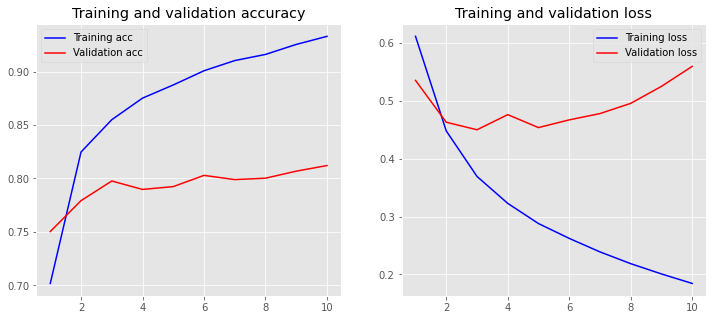

In [104]:
features_history = modelFeatures.fit(train_more_feature.drop(columns=["target"]).to_numpy(dtype="float32"), train_more_feature[["target"]].to_numpy(dtype="float32"),
                    epochs=10,
                    verbose=True,
                    validation_data=(val_more_feature.drop(columns=["target"]).to_numpy(dtype="float32"), val_more_feature[["target"]].to_numpy(dtype="float32")),
                    batch_size=10)
loss, accuracy = modelFeatures.evaluate(train_more_feature.drop(columns=["target"]).to_numpy(dtype="float32"), train_more_feature[["target"]].to_numpy(dtype="float32"), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = modelFeatures.evaluate(test_more_feature.drop(columns=["target"]).to_numpy(dtype="float32"), test_more_feature[["target"]].to_numpy(dtype="float32"), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(features_history)

In [105]:
moreFeaturesPredictions = list(map(lambda x: x[0], modelFeatures.predict_classes(test_limpio.drop(columns=["id"]).to_numpy(dtype="float32"))))

In [106]:
moreFeaturesPredictionsDF = pd.DataFrame(data={'id': test_limpio["id"], 'target': moreFeaturesPredictions})
moreFeaturesPredictionsDF.head(10)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [107]:
moreFeaturesPredictionsDF.to_csv('NN_predictions_more_features.csv', index=False)